In [17]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [18]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [20]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [21]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [22]:
# View all of the classes that automap found
measure = Base.classes.measurement


session = Session(engine)
results = session.query(measure).limit(10).all()

for result in results:
    print(result)


In [23]:
inspector = inspect(engine)
inspector.get_table_names()

# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [24]:
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [25]:
# Save references to each table
station = Base.classes.station

In [26]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [39]:
# Find the most recent date in the data set.
session.query(measure.date).order_by(measure.date.desc()).first()[0]


'2017-08-23'

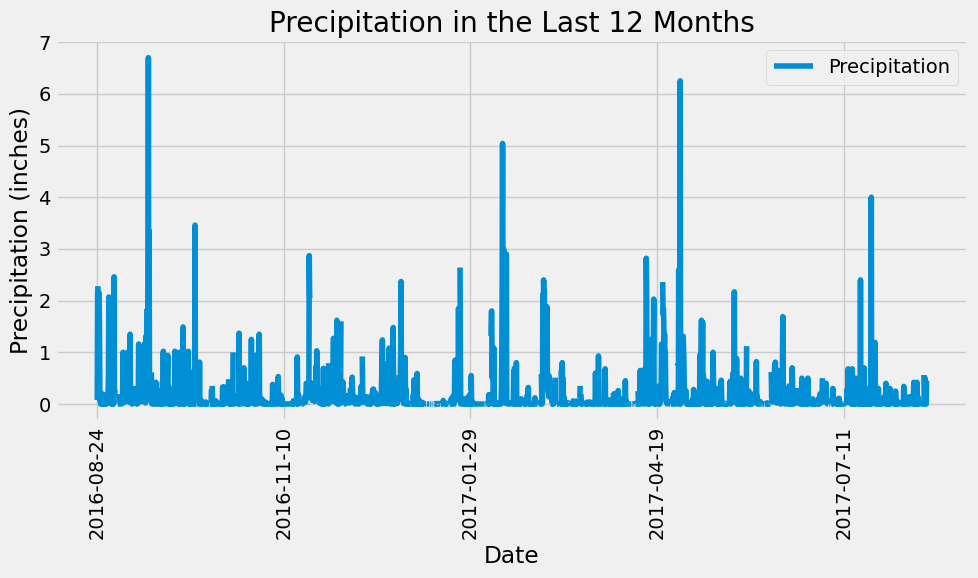

In [37]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
latest_date = session.query(measure.date).order_by(measure.date.desc()).first()[0]
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
one_year_ago = latest_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measure.date, measure.prcp).\
    filter(measure.date >= one_year_ago).\
    order_by(measure.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df.sort_values('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.set_index('Date', inplace=True)
precipitation_df.plot(figsize=(10, 6), title="Precipitation in the Last 12 Months", ylabel="Precipitation (inches)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [38]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df.describe()

print(summary_statistics)

       Precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [41]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.station)).scalar()

9

In [46]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")



Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [49]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)
).filter(measurement.station == most_active_station).all()

print(temperature_stats)

[(54.0, 85.0, 71.66378066378067)]


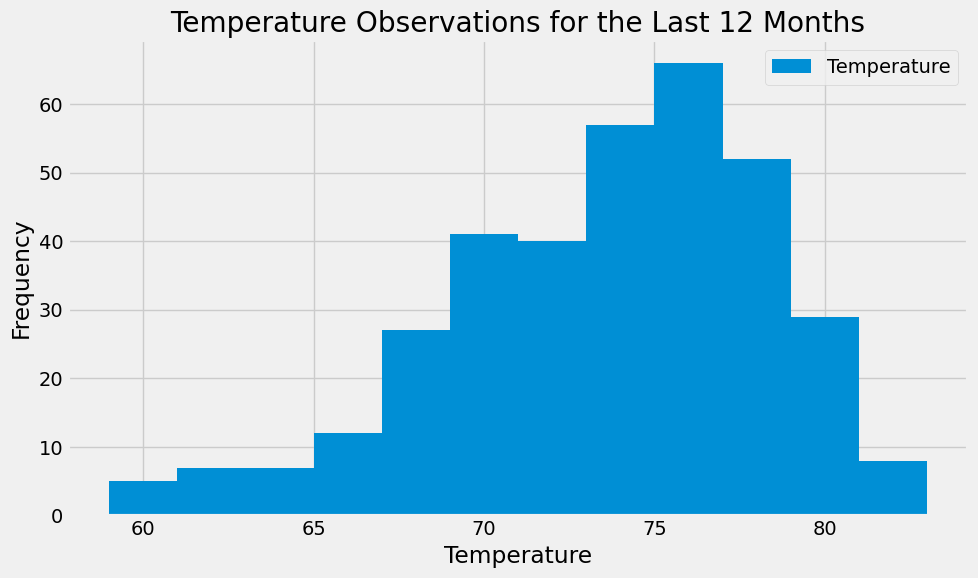

In [63]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == most_active_station).\
    filter(measurement.date >= one_year_ago).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

# Plot the results as a histogram
temperature_df['Temperature'].plot(kind='hist', bins=12, figsize=(10, 6), title="Temperature Observations for the Last 12 Months")
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [51]:
# Close Session
session.close()